In [1]:
from transformers import BertForSequenceClassification
from transformers import BertTokenizer
from transformers import pipeline

IDEA-CCNL 文件夹存放 IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment 模型所对应的三个文件

config.json：配置文件

vocab.json：词典文件

pytorch_model.bin：预训练模型文件

IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment

## 1.加载模型和分词器

In [2]:
# 加载分词器
# tokenizer=BertTokenizer.from_pretrained('./IDEA-CCNL')  # vocab.txt 将模型放在当前目录的 IDEA-CCNL 文件夹
tokenizer=BertTokenizer.from_pretrained('IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment')  # 第一次运行会自动从官网下载，大概 400M
# 加载模型
# model=BertForSequenceClassification.from_pretrained('./IDEA-CCNL')  # pytorch_model.bin
model=BertForSequenceClassification.from_pretrained('IDEA-CCNL/Erlangshen-Roberta-110M-Sentiment')


In [3]:
pipe = pipeline("text-classification", model=model, tokenizer=tokenizer)

In [4]:
text = ['当年是真穷啊', '光刻机是绕不开的痛，你设计得出芯片你也造不出来']

In [5]:
pipe(text)

[{'label': 'Negative', 'score': 0.8296910524368286},
 {'label': 'Negative', 'score': 0.9934822916984558}]

## 2.读取弹幕

In [45]:
import pandas as pd
from tqdm import tqdm  # 进度条

In [46]:
file_path = './data/new_BV1UG411g7Hb.csv'

In [47]:
# 读取csv文件
df = pd.read_csv(file_path, encoding='GB18030')
comments = df['弹幕内容'].tolist()

## 3.分析弹幕情感

In [48]:
# 使用pipeline分析
results = []
with tqdm(total=len(comments), desc='分析中') as pbar:
    for comment in comments:
        result = pipe(comment)
        if result[0]['label'] == 'Positive':
            result[0]['label'] = '积极'
        else:
            result[0]['label'] = '消极'
        results.append(result)
        pbar.update(1)

分析中: 100%|██████████| 13870/13870 [21:29<00:00, 10.76it/s]


## 4.存储结果

In [49]:
# 在DataFrame中添加“态度”和“得分”列
df['态度'] = [result[0]['label'] for result in results]
df['得分'] = [result[0]['score'] for result in results]

In [50]:
# 更新原始CSV文件
df.to_csv(file_path, index=False, encoding='GB18030')  

## 5.可视化展示

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

plt.rcParams['font.sans-serif']=['SimHei','Songti SC','STFangsong']  # macOS 和 windows 通用
plt.rcParams['axes.unicode_minus'] = False   # 用来正常显示表示负号

In [52]:
df = pd.read_csv(file_path, encoding='GB18030')

### 绘制弹幕发送时间的折线图

In [53]:
# 将发送时间转换为日期格式
df['弹幕发送时间'] = pd.to_datetime(df['弹幕发送时间'])
# 按日期排序
df = df.sort_values('弹幕发送时间')

In [54]:
# 创建一个新的列来表示每天的弹幕累计数量
df['累计弹幕数量'] = range(1, len(df) + 1)

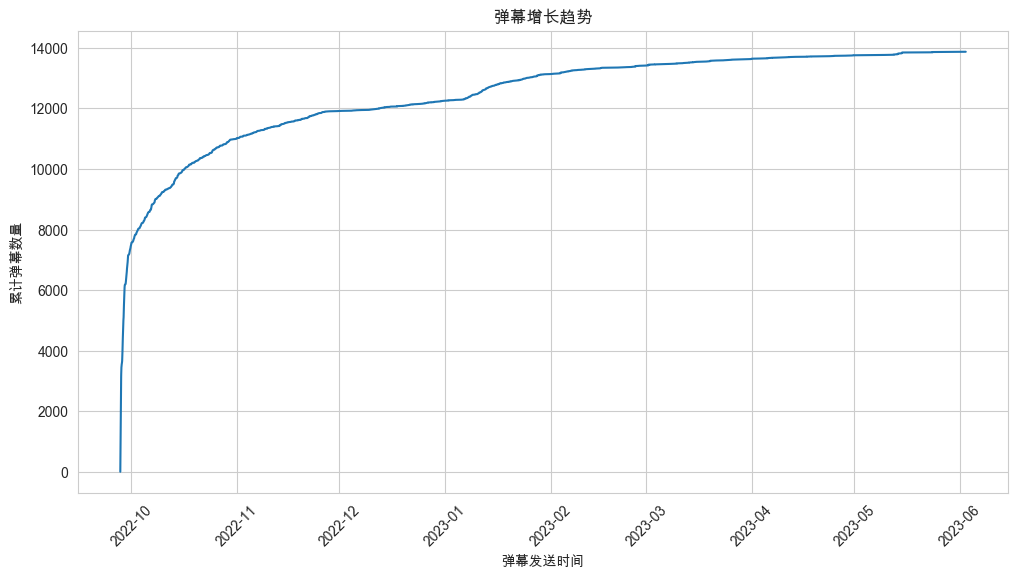

In [55]:
# 设置图表样式
plt.figure(figsize=(12, 6))

# 绘制折线图
plt.plot(df['弹幕发送时间'], df['累计弹幕数量'])

# 设置轴标签和标题
plt.xlabel('弹幕发送时间')
plt.ylabel('累计弹幕数量')
plt.title('弹幕增长趋势')

# 旋转日期标签
plt.xticks(rotation=45)

# 显示图表
plt.show()

### 统计不同态度的弹幕数量，绘制饼图

In [56]:
df = pd.read_csv(file_path, encoding='GB18030')

# 统计不同态度的弹幕数量
attitude_counts = df['态度'].value_counts()

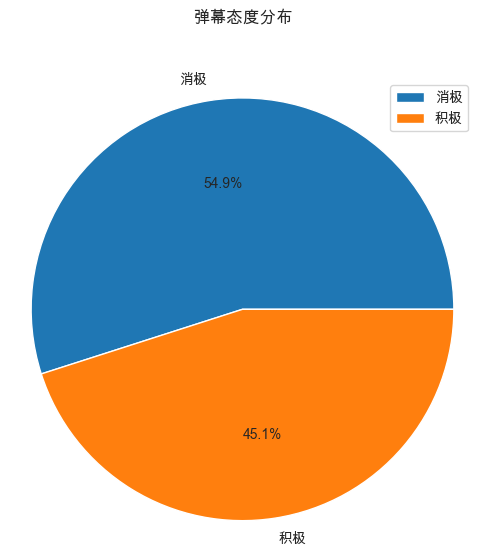

In [57]:
# 绘制态度的饼图
plt.figure(figsize=(6, 6))
plt.pie(attitude_counts, labels=attitude_counts.index, autopct='%1.1f%%')
plt.title('弹幕态度分布', pad=40)
plt.legend()
plt.axis('equal')
plt.show()

### 统计不同态度的弹幕分数，绘制核密度估计图

In [58]:
# 分离不同态度的弹幕分数
positive_scores = df[df['态度'] == '积极']['得分']
negative_scores = df[df['态度'] == '消极']['得分']
positive_scores

0        0.941230
1        0.921841
8        0.744972
13       0.932588
16       0.608894
           ...   
13861    0.805986
13862    0.795419
13865    0.686249
13866    0.992940
13869    0.908588
Name: 得分, Length: 6249, dtype: float64

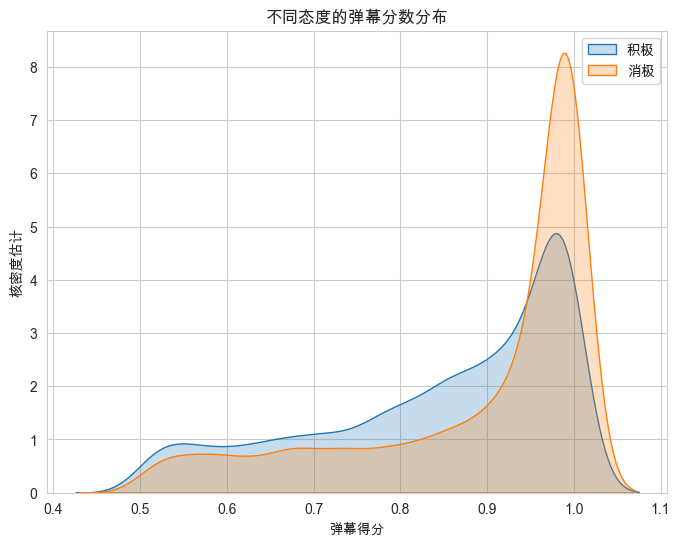

In [59]:
import seaborn as sns

# 设置图表样式
sns.set_style('whitegrid')
# 设置中文字体
plt.rcParams['font.family'] = ['Arial Unicode MS']  # 针对 macOS 设置中文字体

# 绘制KDE图
plt.figure(figsize=(8, 6))
sns.kdeplot(positive_scores, fill=True, label='积极')
sns.kdeplot(negative_scores, fill=True, label='消极')

# 添加标题和标签
plt.title('不同态度的弹幕分数分布')
plt.xlabel('弹幕得分')
plt.ylabel('核密度估计')

# 添加图例
plt.legend()

# 显示图表
plt.show()

绘制核密度估计图可以展示数据的分布形态，通过平滑的曲线展示不同数值范围内数据的相对密度。

### 统计关键词，制作词云图

In [60]:
from wordcloud import WordCloud, ImageColorGenerator
import jieba
import re
import numpy as np
from PIL import Image

In [61]:
# 弹幕内容预处理和分词操作
def preprocess_text(text):
    # 去除特殊字符
    text = re.sub(r'[^\u4e00-\u9fa5a-zA-Z0-9]', '', text)
    # 分词操作
    seg_list = jieba.cut(text)
    # 去除停用词
    stop_words = set()
    with open('cn_stopwords.txt', 'r', encoding='utf-8') as f:
        for line in f:
            stop_words.add(line.strip())
    seg_list = [word for word in seg_list if word not in stop_words]
    # 返回分词结果
    return seg_list

In [62]:
df = pd.read_csv(file_path, encoding='GB18030')
# 对每条弹幕内容进行预处理和分词
df['分词内容'] = df['弹幕内容'].apply(preprocess_text)

In [63]:
df

,弹幕id,弹幕所处位置,弹幕发送时间,弹幕内容,态度,得分,分词内容
0,A1150943824529692416,30:34,2022-09-27 23:59:55,我选特斯拉，跟林志颖交朋友,积极,0.941230,"[我选, 特斯拉, 林志颖, 交朋友]"
1,A1150943706694761472,17:04,2022-09-27 23:59:41,笑死，哈哈哈哈,积极,0.921841,"[笑, 死, 哈哈哈哈]"
2,A1150943598809184256,09:24,2022-09-27 23:59:28,说好看的 一定没有基本的审美素养………,消极,0.988726,"[说, 好看, 一定, 没有, 基本, 审美, 素养]"
3,A1150943565959291136,06:22,2022-09-27 23:59:24,车撞坏了，修改来更贵了,消极,0.989875,"[车, 撞坏, 修改, 更, 贵]"
4,A1150943480814881280,34:01,2022-09-27 23:59:14,有发召回啊,消极,0.733820,"[有发, 召回]"
...,...,...,...,...,...,...,...
13865,A1327459816532456704,02:22,2023-05-29 13:05:41,苹果的简洁是高级感，特斯拉的简洁是简陋,积极,0.686249,"[苹果, 简洁, 高级, 感, 特斯拉, 简洁, 简陋]"
13866,A1329224440554407424,11:11,2023-05-31 23:31:41,比亚迪起家做车就是模仿丰田热门款可以算是小迷弟,积极,0.992940,"[比亚迪, 起家, 做车, 模仿, 丰田, 热门, 款, 算是, 小迷弟]"
13867,A1329097138185255936,01:56,2023-05-31 19:18:45,外观都差不多啊,消极,0.957421,"[外观, 差不多]"
13868,A1328883843448535552,01:56,2023-05-31 12:14:58,又多又杂,消极,0.995129,[杂]


In [64]:
# 统计关键词的频率
keywords = [word for word_list in df['分词内容'] for word in word_list]
keyword_counts = pd.Series(keywords).value_counts()
keyword_counts

特斯拉       1664
比亚迪        911
哈哈哈        909
说          606
海豹         550
          ... 
改掉           1
哥七头哥         1
我想           1
Moldey       1
彊            1
Name: count, Length: 10054, dtype: int64

In [65]:
# 加载模板图片
image_path = './mask.png'
image_mask = np.array(Image.open(image_path))
image_mask[image_mask < 150] = 0
image_mask[image_mask > 220] = 255

In [66]:
# 生成词云图
wordcloud = WordCloud(background_color='white', mask=image_mask, font_path='./LXGWWenKai-Regular.ttf').generate_from_frequencies(keyword_counts)

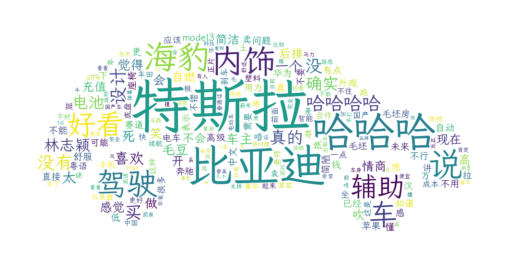

In [67]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### 以1min为间隔，统计视频弹幕条数，绘制折线图

In [68]:
from scipy.signal import argrelextrema

In [69]:
#  提取分钟部分并计算每分钟的弹幕数量
df['分钟'] = df['弹幕所处位置'].str.split(':').str[0]
minute_counts = df['分钟'].value_counts().sort_index()

In [70]:
# 找到局部最大值的索引
local_max_indices = argrelextrema(minute_counts.values, np.greater)[0]
local_max_values = minute_counts.values[local_max_indices]
local_max_minutes = minute_counts.index[local_max_indices]

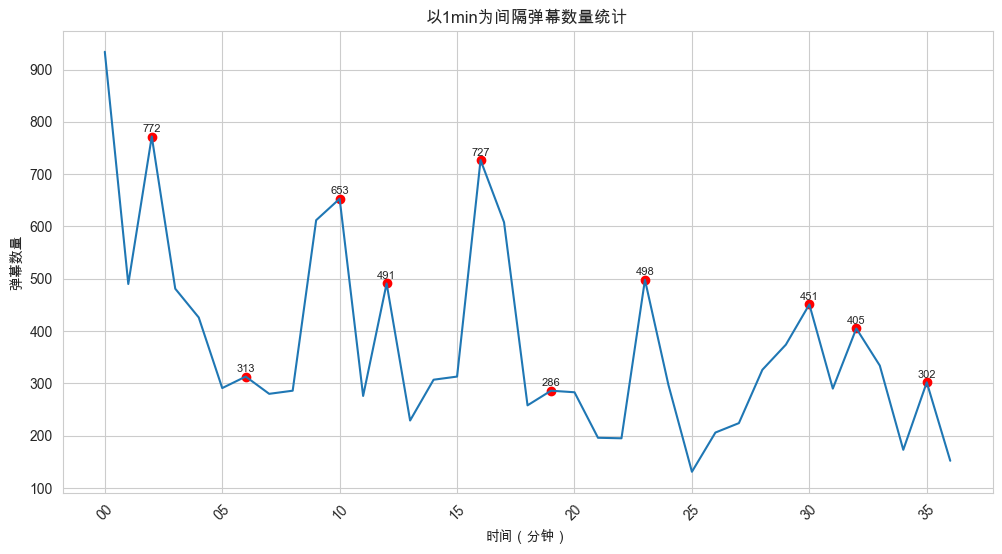

In [71]:
# 绘制折线图
# 设置字体
plt.rcParams['font.family'] = ['Arial Unicode MS']  # 针对 macOS 设置中文字体
plt.figure(figsize=(12, 6))
plt.plot(minute_counts.index, minute_counts.values)
plt.scatter(local_max_minutes, local_max_values, color='r', label='局部最大值')
plt.xlabel('时间（分钟）')
plt.ylabel('弹幕数量')
plt.title('以1min为间隔弹幕数量统计')
plt.xticks(rotation=45)

# 设置x轴刻度间隔为5分钟
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(5))

# 在局部最大值处添加数值标注
for i in range(len(local_max_minutes)):
    plt.text(local_max_minutes[i], local_max_values[i] + 5, str(local_max_values[i]), ha='center', va='bottom', fontsize=8)

plt.show()